Data Loading

In [19]:
import scanpy as sc
import numpy as np
import pandas as pd
import scvi
import anndata
import scipy

In [2]:
sc.set_figure_params(dpi = 100, fontsize = 12, facecolor='white')

In [3]:
adata = scvi.data.cortex()

INFO     File /home/sakary/hamim/data/expression.bin already downloaded                      
INFO     Loading Cortex data from /home/sakary/hamim/data/expression.bin                     
INFO     Finished loading Cortex data                                                        
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["labels"]                                               


/home/sakary/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 3005 cells, 19972 vars, 1 batches,
         7 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Pre-Processing

In [4]:
adata.var['mt']=adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'],percent_top=None,log1p=False,inplace=True)
sc.pp.filter_genes(adata, min_cells=3)

In [14]:
adata.obs

,labels,precise_labels,cell_type,_scvi_batch,_scvi_labels,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,n_counts
0,2,1,interneurons,0,2,4848,21580.0,0.0,0.0,4848,21580.0
1,2,1,interneurons,0,2,4685,21748.0,0.0,0.0,4684,21747.0
2,2,1,interneurons,0,2,6028,31642.0,0.0,0.0,6026,31640.0
3,2,1,interneurons,0,2,5824,32914.0,0.0,0.0,5824,32914.0
4,2,1,interneurons,0,2,4701,21530.0,0.0,0.0,4700,21528.0
...,...,...,...,...,...,...,...,...,...,...,...
3000,1,9,endothelial-mural,0,1,2221,4585.0,0.0,0.0,2220,4584.0
3001,1,9,endothelial-mural,0,1,1428,2559.0,0.0,0.0,1428,2559.0
3002,1,9,endothelial-mural,0,1,1977,4015.0,0.0,0.0,1976,4014.0
3003,1,9,endothelial-mural,0,1,1493,2896.0,0.0,0.0,1493,2896.0


/home/sakary/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'precise_labels' as categorical
/home/sakary/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


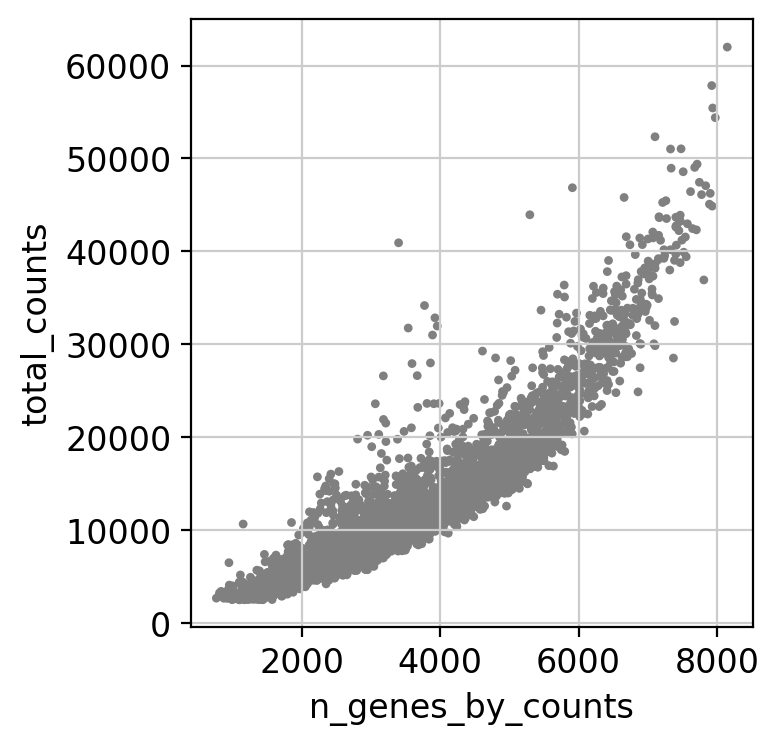

In [7]:
sc.pl.scatter(adata,"n_genes_by_counts","total_counts")

In [8]:
sc.pp.filter_cells(adata,max_genes=7500, inplace=True, copy=False)
sc.pp.filter_cells(adata,max_counts=45000, inplace=True, copy=False)

Normalization


In [9]:
adata.layers["counts"]=adata.X.copy()
sc.pp.normalize_total(adata,target_sum=10000)
sc.pp.log1p(adata)
adata.raw=adata

In [10]:
sc.pp.highly_variable_genes(adata,n_top_genes=3500,layer="counts",flavor="seurat_v3")

In [11]:
adata = adata[:, adata.var.highly_variable].copy()

In [12]:
sc.tl.pca(adata, svd_solver='arpack')

In [16]:
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
import scanpy.external as sce
import matplotlib.pyplot as plt
import numba

Finding the right resolution

euclidean
correlation


<function matplotlib.pyplot.show(close=None, block=None)>

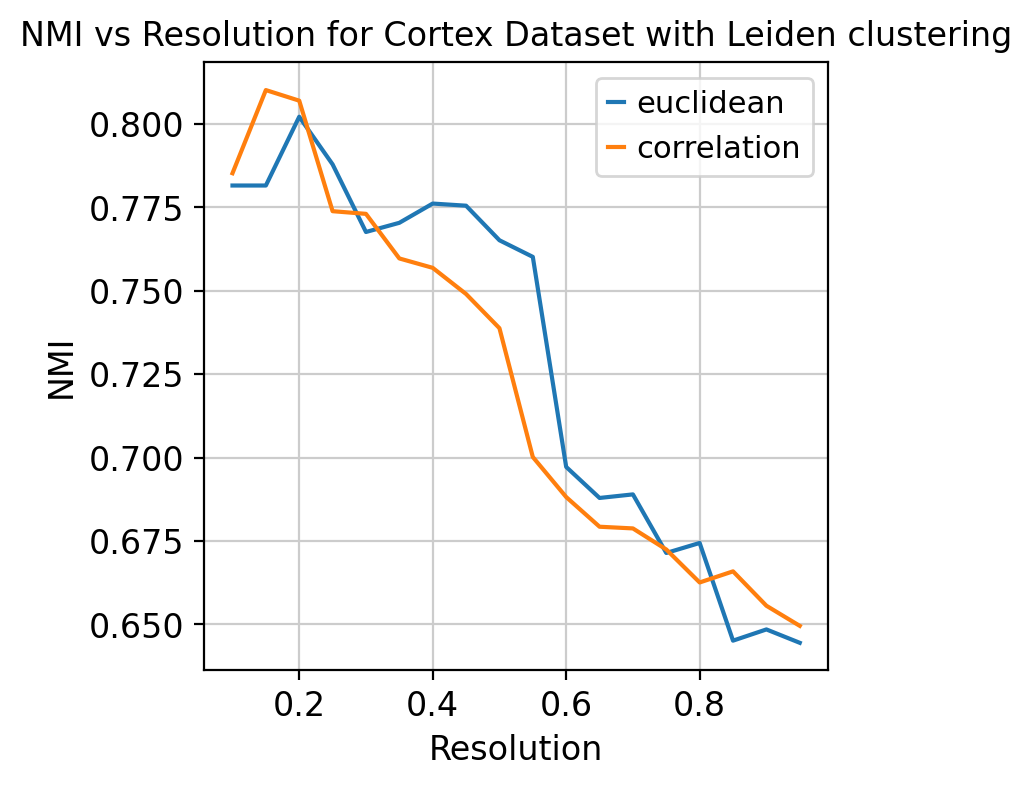

In [15]:
lst = ['euclidean', 'correlation']
lsteuc = []
lstcor = []
lstres = []
df = pd.DataFrame(columns=lst, index=['NMI'])
for x in lst:
    print(x)
    res = 0.1
    while res <= 1.0:
        lstres.append(res)
        sc.pp.neighbors(adata, metric=x)
        sc.tl.leiden(adata, resolution=res)
        if(x == 'euclidean'):
            lsteuc.append(normalized_mutual_info_score(
                adata.obs["cell_type"], adata.obs['leiden']))
        if(x == 'correlation'):
            lstcor.append(normalized_mutual_info_score(
                adata.obs["cell_type"], adata.obs['leiden']))
        res = res+0.05
lstres = lstres[:18]
plt.plot(lstres, lsteuc, label='euclidean')
plt.plot(lstres, lstcor, label='correlation')
plt.xlabel('Resolution')
plt.ylabel('NMI')
plt.title("NMI vs Resolution for Cortex Dataset with Leiden clustering")
plt.legend()
plt.show

Clustering

In [17]:
@numba.njit(fastmath=True)
def Polaratio(x, y):
    n = x.size
    num = 0
    for j in range(0, n):  # O(n^2)
        for i in range(0, j):
            num += max(0, (x[j] - x[i]) * (y[i] - y[j]))
    return num / (num + n * np.cov(x, y)[0][1])


Different Distance Matrices

In [18]:
lst = ['cosine', 'euclidean', 'correlation', 'manhattan',
        'braycurtis', 'canberra', 'chebyshev', 'minkowski']
df_low= pd.DataFrame(columns=lst, index=['NMI', 'ARI', "FM"])
df_leiden = pd.DataFrame(columns=lst, index=['NMI', 'ARI', "FM"])
df_mid = pd.DataFrame(columns=lst, index=['NMI', 'ARI', "FM"])
for x in lst:
    print(x)
    if(x=='minkowski'):
        sc.pp.neighbors(adata, metric=x,metric_kwds={'p':0.5})
        sc.tl.leiden(adata, resolution=0.15)
        df_low.at["NMI", x + '(0.5)'] = normalized_mutual_info_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        df_low.at["ARI", x + '(0.5)'] = adjusted_rand_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        df_low.at["FM", x + '(0.5)'] = fowlkes_mallows_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        sc.tl.leiden(adata, resolution=0.50)
        df_mid.at["NMI", x + '(0.5)'] = normalized_mutual_info_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        df_mid.at["ARI", x + '(0.5)'] = adjusted_rand_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        df_mid.at["FM", x + '(0.5)'] = fowlkes_mallows_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        sc.pp.neighbors(adata, metric=x, metric_kwds={'p': 0.1})
        sc.tl.leiden(adata, resolution=0.15)
        df_low.at["NMI", x + '(0.1)'] = normalized_mutual_info_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        df_low.at["ARI", x + '(0.1)'] = adjusted_rand_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        df_low.at["FM", x + '(0.1)'] = fowlkes_mallows_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        sc.tl.leiden(adata, resolution=0.50)
        df_mid.at["NMI", x + '(0.1)'] = normalized_mutual_info_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        df_mid.at["ARI", x + '(0.1)'] = adjusted_rand_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        df_mid.at["FM", x + '(0.1)'] = fowlkes_mallows_score(
            adata.obs["cell_type"], adata.obs['leiden'])
    else:
        sc.pp.neighbors(adata, metric=x)
        sc.tl.leiden(adata, resolution=0.15)
        df_low.at["NMI", x] = normalized_mutual_info_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        df_low.at["ARI", x] = adjusted_rand_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        df_low.at["FM", x] = fowlkes_mallows_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        sc.tl.leiden(adata, resolution=0.50)
        df_mid.at["NMI", x] = normalized_mutual_info_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        df_mid.at["ARI", x] = adjusted_rand_score(
            adata.obs["cell_type"], adata.obs['leiden'])
        df_mid.at["FM", x] = fowlkes_mallows_score(
            adata.obs["cell_type"], adata.obs['leiden'])


cosine
euclidean
correlation
manhattan
braycurtis
canberra
chebyshev
minkowski


Polaratio

In [20]:
print("Polaratio")
sc.pp.neighbors(adata, metric=Polaratio)
sc.tl.leiden(adata, resolution=0.15)
df_low.at["NMI", "Polaratio"] = normalized_mutual_info_score(
    adata.obs["cell_type"], adata.obs['leiden'])
df_low.at["ARI", "Polaratio"] = adjusted_rand_score(
    adata.obs["cell_type"], adata.obs['leiden'])
df_low.at["FM", "Polaratio"] = fowlkes_mallows_score(
    adata.obs["cell_type"], adata.obs['leiden'])
sc.tl.leiden(adata, resolution=0.50)
df_mid.at["NMI", "Polaratio"] = normalized_mutual_info_score(
    adata.obs["cell_type"], adata.obs['leiden'])
df_mid.at["ARI", "Polaratio"] = adjusted_rand_score(
    adata.obs["cell_type"], adata.obs['leiden'])
df_mid.at["FM", "Polaratio"] = fowlkes_mallows_score(
    adata.obs["cell_type"], adata.obs['leiden'])

#print(df_low)
#print(df_mid)
# print(df_louvain)
#df_low.to_excel('cortex_low.xlsx')
#df_mid.to_excel('cortex_mid.xlsx')

Polaratio


Geodesic

In [21]:
sc.pp.neighbors(adata,n_neighbors=500,metric="cosine")
bdata = adata.obsp["distances"]
cdata = scipy.sparse.csgraph.shortest_path(bdata, directed = False)

In [40]:
#adata.obsp["distances"] = cdata

In [41]:
cdata[1,:]

array([0.07674605, 0.        , 0.10242474, ..., 0.43441945, 0.43443263,
       0.43443692])

In [22]:
n = adata.X.shape[0]
for i in range(n):
    adata.obsm['X_pca'][i][49] = i

def geodesic(A,B):
    global cdata
    return cdata[int(A[49])][int(B[49])]

In [24]:
print("geodesic")
sc.pp.neighbors(adata, metric=geodesic)
sc.tl.leiden(adata, resolution=0.15)
df_low.at["NMI", "Geodesic"] = normalized_mutual_info_score(
    adata.obs["cell_type"], adata.obs['leiden'])
df_low.at["ARI", "Geodesic"] = adjusted_rand_score(
    adata.obs["cell_type"], adata.obs['leiden'])
df_low.at["FM", "Geodesic"] = fowlkes_mallows_score(
    adata.obs["cell_type"], adata.obs['leiden'])
sc.tl.leiden(adata, resolution=0.50)
df_mid.at["NMI", "Geodesic"] = normalized_mutual_info_score(
    adata.obs["cell_type"], adata.obs['leiden'])
df_mid.at["ARI", "Geodesic"] = adjusted_rand_score(
    adata.obs["cell_type"], adata.obs['leiden'])
df_mid.at["FM", "Geodesic"] = fowlkes_mallows_score(
    adata.obs["cell_type"], adata.obs['leiden'])

print(df_low)
print(df_mid)
# print(df_louvain)


geodesic
       cosine euclidean correlation manhattan braycurtis  canberra chebyshev  \
NMI  0.820912  0.781537    0.810141  0.777984   0.816154  0.672035  0.799283   
ARI  0.855259  0.825236    0.857164   0.82491   0.867185  0.615314  0.824078   
FM   0.885956  0.865749    0.887074   0.86562   0.895785  0.727124  0.861317   

    minkowski  minkowski(0.5)  minkowski(0.1)  Polaratio  Geodesic  
NMI       NaN        0.779102        0.671112   0.816147  0.790738  
ARI       NaN        0.831360        0.626132   0.854935  0.822153  
FM        NaN        0.870644        0.737615   0.885561  0.859876  
       cosine euclidean correlation manhattan braycurtis  canberra chebyshev  \
NMI  0.728426  0.765127    0.738771   0.75912   0.748206  0.692068  0.741683   
ARI  0.650401  0.702826    0.696998  0.749845    0.74872  0.708425  0.635594   
FM   0.729207  0.768631    0.764436    0.8042   0.803425  0.768667  0.715996   

    minkowski  minkowski(0.5)  minkowski(0.1)  Polaratio  Geodesic  
NMI 

In [25]:
df_low.to_excel('cortex_low.xlsx')
df_mid.to_excel('cortex_mid.xlsx')